<a href="https://colab.research.google.com/github/BenjaminLAZARD/Interviews/blob/main/Upflowy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Given the attached image I want you to create a jupyter notebook that you will send through as the test outcome. You will need to do the following:
1. identify a hugging-face model that can process the image to text
2. The goal of the image to text is to identify the title, body text and button text of the image and return it labelled correctly with text values returned. eg {
    title: "The title text",
    body: "the body text",
    button: "the button text"
}
3. import a pre-trained version of the model into your notebook
4. import the provided image and make it ready for prediction with the model
5. run the prediction and output the results

The aim of this exercise is to demonstrate your skills in assessing and using a pre-trained model on the type of subject matter we will be using. While the accuracy of the result is not part of the assessment as we are not expecting you to fine-tune the pre-trained model, your ability to choose a model that demonstrates it has the potential to achieve the accuracy with fine tuning will be considered.

I need you to time-box the work on this to not more than 2 hours, so you need to think carefully about how you allocate your time to the different parts of this task. Please make small regular commits to a git repository to demonstrate your work methodology and the time taken. If you don't complete the task in the 2 hours, please submit what you have achieved.


# 1.

Identifying some huggingface models that can process image to text and label correctly each text as per the document. Or identify strategies to reach that goal.

## 1.1 Finding a model specifically designed for such labelization

## 1.2 Finding a model that can do OCR and return metadata
If we can retrieve not only the text, but also elements like fontsize and boundingboxes, we can use hand-made rules to classify the texts (for example the bigger font and shortest text can be a title, or a button will have a different background color than the rest).

https://huggingface.co/docs/transformers/v4.19.2/en/model_doc/layoutlmv2 -> seems to be returning bounding boxes, question answering can be attempted to ask for the different output json parts.

Did not find such a model
[Donut model](https://huggingface.co/docs/transformers/main/en/model_doc/donut#inference-examples) is somewhat close.

## 1.3 Finding a model that can do only OCR but still separate texts detected, then use traditional NLP techniques
A button will contain few words for example, likely be a verb or start by one. Maybe there exist some models to claissfy content in some way we could use.

This is not huggingface, but [this tutorial](https://nanonets.com/blog/ocr-with-tesseract/) mentions the use of Google's Tesseract and includes a hack for visualization of bounding boxes around detected text. This can be a great if we don't plan to finetune the OCR part.

There exist the pipeline("image-to-text", model= <>) tool to use TOCR models (but it is designed mostly for single line texts).

## 1.4 Preprocessing the image manually
Instead of directly applying a huggingface model, one could actually use a library like opencv2, or the base of a HF architecture to simply split the image into different text areas, then run the OCR on each independently (for example as in [this tutorial](https://huggingface.co/vanshp123/ocrmnist) )


## Thinking further

Although this is out of the scope of this exercise, it would be interesting to combine approach from [1.2]() together with a classifier that could be trained in-house with the three categories (or more) [title, body, button].

For training, the logic mentionned in [this tutorial](https://www.youtube.com/watch?v=aGcLSH9TTLU) could be used




In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,475 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [4]:
#Trying to move forward with layoutLMV2

from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

image = Image.open("sample_image.png").convert("RGB")
encoding = processor(image, return_tensors="pt")  # you can also add all tokenizer parameters here such as padding, truncation

In [6]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

In [11]:
processor.tokenizer.decode(encoding["input_ids"][0])

'[CLS] take your development to the next level whether you are just getting started on arm or looking for resources to help you create top - performing software solutions, arm developer hub has everything you need to start building better software and deliver rich experiences for billions of devices. download, learn, connect, and question within our growing global developer community. explore arm developer hub [SEP]'

## Conclusion 1

So we actually don't get the bounding boxes per section as we wanted... It is however very interesting to note that using only the tesseract part to get "blocks", then using this model to embed text and image and fine-tune it as a classifier for type of button seems to be exactly what we need.

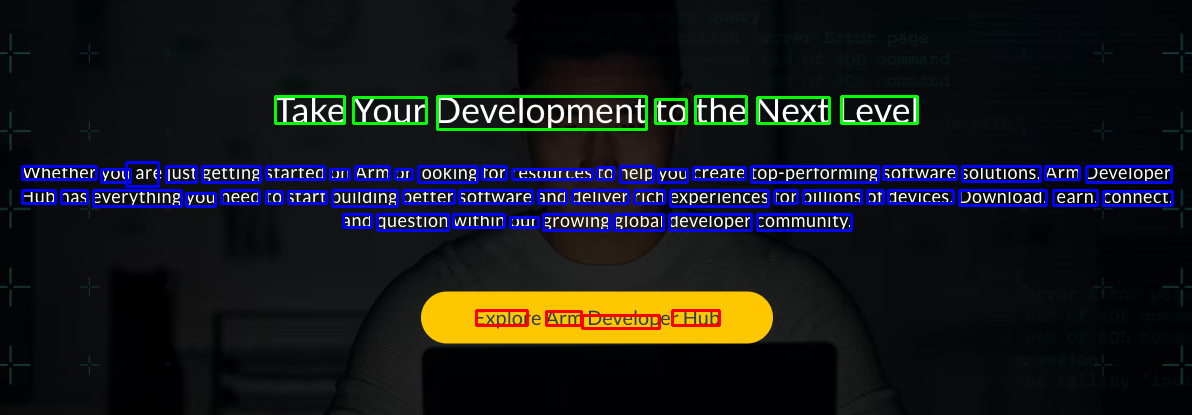

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [31]:
# Now trying another option: using directly tesseract since this is included in the preprocessor above in any case
import cv2
from google.colab.patches import cv2_imshow
import pytesseract
from pytesseract import Output

img = cv2.imread('sample_image.png')

d = pytesseract.image_to_data(img, output_type=Output.DICT, )
title_color = (0, 255, 0)
body_color = (255, 0, 0)
button_color = (0, 0, 255)
block_colors = [(0,0,0), title_color, body_color, button_color]

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), block_colors[d["block_num"][i]], 2)

cv2_imshow(img)
print(d.keys())

In [35]:
d["conf"]

[-1,
 -1,
 -1,
 -1,
 96,
 96,
 96,
 95,
 96,
 96,
 96,
 -1,
 -1,
 -1,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 -1,
 96,
 95,
 95,
 96,
 96,
 96,
 97,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 95,
 96,
 96,
 -1,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 -1,
 -1,
 -1,
 96,
 96,
 96,
 96]

In [32]:
# So at this stage we have properly identified blocks... we can go further and identify the block bounding boxes

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1]